# Analysis of CIA Factbook Data through SQLite and R

The [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/) is a compendium of statistics about all the countries in the world, and contains information like:

- `population` - Population as of 2015.
- `population_growth` - The annual population growth rate, as a percentage.
- `area` - Total Area including land and Water.



The database file we'll be working with is `factbook.db`. We'll query this database and later perform visualization tasks to convert the information within the database into a form that makes it easier for us to learn about each country.


First, we'll import the necessary libraries:

In [1]:
library(RSQLite)
library(DBI)

Warning message:
"package 'RSQLite' was built under R version 3.6.1"

Lets get connected with the database, and run a query that displays the first 5 rows of the `facts` dataframe stored within the `factbook.db` database file.

In [2]:
conn <- dbConnect(SQLite(), "factbook.db")

query <- "SELECT * FROM facts LIMIT 5"

result <- dbSendQuery(conn, query)

first_5 <- dbFetch(result)

first_5

id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


The descriptions of some of the columns are as follows:

- name - The name of the country.
- area - The total land and sea area of the country (represented by the area_land and area_water columns).
- area_land - The country's land area in square kilometers.
- area_water - The country's waterarea in square kilometers.
- population - The country's population as of 2015
- population_growth - The country's population growth as a percentage.
- birth_rate - The country's birth rate, or the number of births a year per 1,000 people.
- death_rate - The country's death rate, or the number of death a year per 1,000 people.



## Calculating Summary Statistics

To start with, we'll begin calculating some summary statistics, and checking for outlier countries in the process. In particluar, we'll check the following things using a query: 

- minimum population
- maximum population
- minimum population growth
- maximum population growth

In [3]:
query2 <- "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts"

result2 <- dbGetQuery(conn, query2)

result2

Warning message:
"Closing open result set, pending rows"

MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,7256490011,0,4.02


Right away, we notice some extremely strange things: 

1) There's a country with a population of 0.

2) There's a country with a population of 7,256,490,011. No single country in 2015 had a population anywhere remotely close to 7 billion!

Let's see what these countries are. 

In [4]:
query3 <- "SELECT name, population FROM facts WHERE population in ((SELECT MIN(population) FROM facts), (SELECT MAX(population) FROM facts))"

result3 <- dbGetQuery(conn, query3)

result3

name,population
Antarctica,0
World,7256490011


## Removing Outliers

We see now that the `facts` dataframe includes Antarctica, and the entire World's population together. This explains the extreme numbers we saw.

Since these outlier rows will skew any visualization we attempt to perform on the dataset, they should be excluded in a revised query.

In [5]:
query4 <- "SELECT * FROM facts WHERE population NOT IN ((SELECT MIN(population) FROM facts), (SELECT MAX(population) FROM facts))"

result4 <- dbGetQuery(conn, query4)

result4

id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072
6,ac,Antigua and Barbuda,442,442,0,92436,1.24,15.85,5.69,2.21,2015-11-01 13:20:13.049627,2015-11-01 13:20:13.049627
7,ar,Argentina,2780400,2736690,43710,43431886,0.93,16.64,7.33,0.00,2015-11-01 13:20:18.233063,2015-11-01 13:20:18.233063
8,am,Armenia,29743,28203,1540,3056382,0.15,13.61,9.34,5.80,2015-11-01 13:20:23.048753,2015-11-01 13:20:23.048753
9,as,Australia,7741220,7682300,58920,22751014,1.07,12.15,7.14,5.65,2015-11-01 13:20:28.186341,2015-11-01 13:20:28.186341
10,au,Austria,83871,82445,1426,8665550,0.55,9.41,9.42,5.56,2015-11-01 13:20:33.093597,2015-11-01 13:20:33.093597


In [6]:
print(max(result4["population"]))

print(dim(result4))

[1] 1367485388
[1] 240  13


## Data Visualization using revised Dataframe

We see above that the result4 tibble now only has 240 rows, and that the maximum population of any country is about 1.3 billion. This figure correctly represents China's population 2015. 

Let's now import a few more libraries that will assist us in our further visualization efforts:

In [7]:
library(tidyverse)
library(ggplot2)
library(dplyr)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.0     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'dplyr' was built under R version 3.6.1"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


We'll plot Histograms for the following columns:

- population
- population_growth
- birth_rate
- death_rate

Let's start by defining a function that will perform this.

Warning message:
"Removed 5 rows containing non-finite values (stat_bin)."

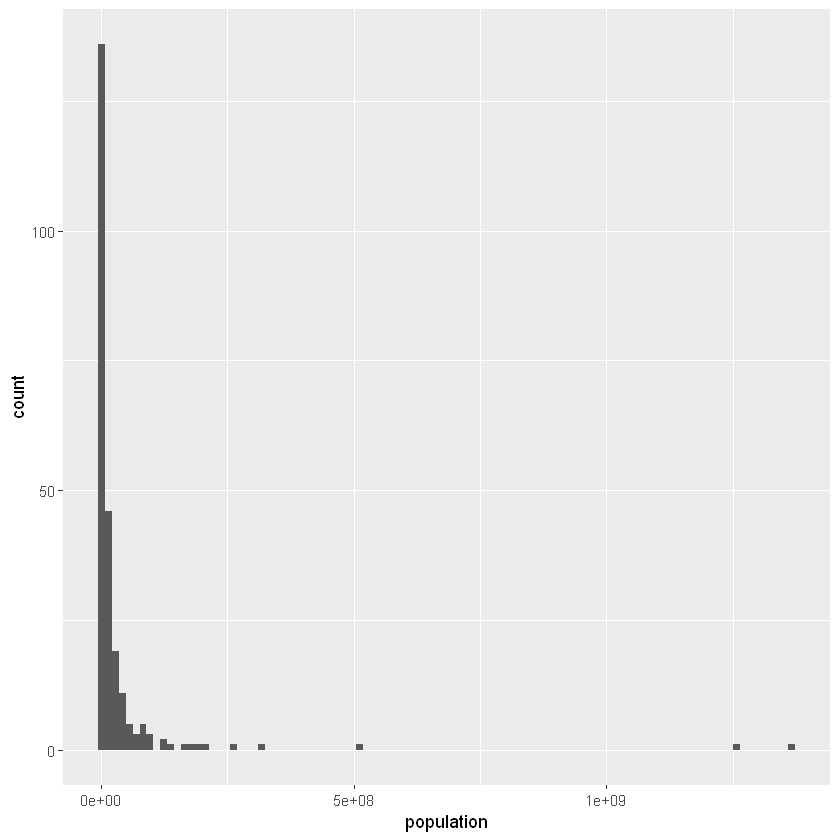

Warning message:
"Removed 13 rows containing non-finite values (stat_bin)."

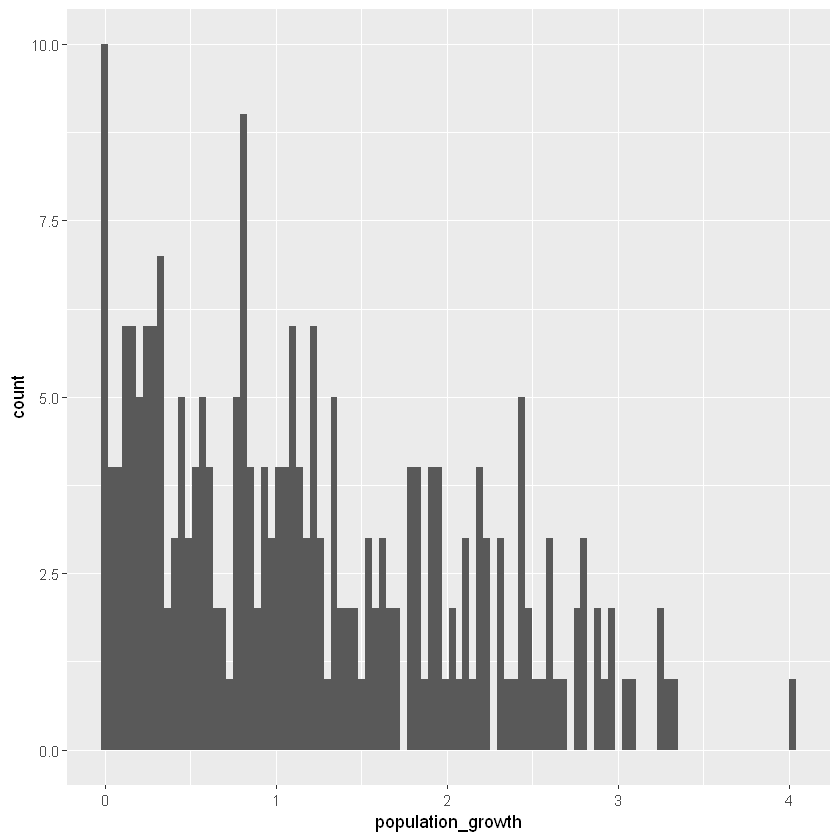

Warning message:
"Removed 13 rows containing non-finite values (stat_bin)."

[[1]]

[[2]]

[[3]]

[[4]]


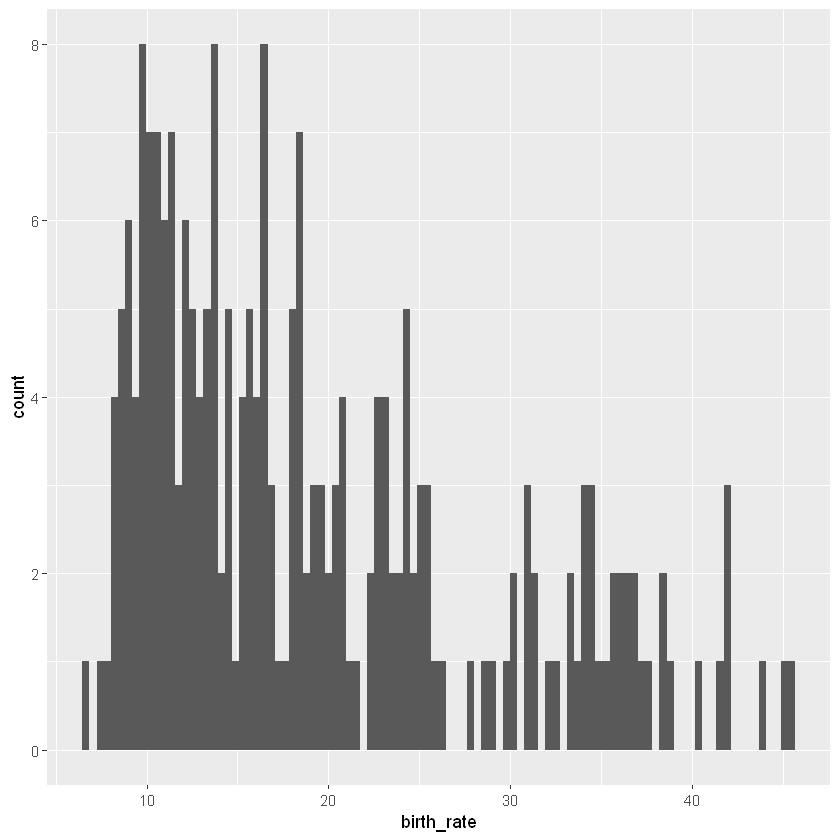

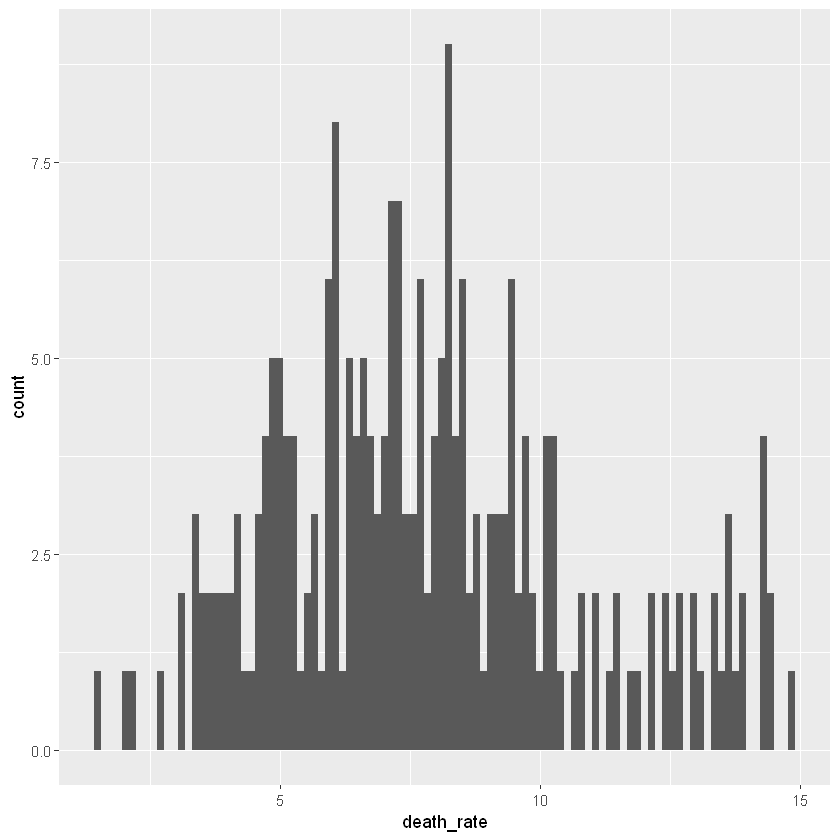

In [16]:
histogram_plot <- function(x){
    ggplot(data = result4) + aes_string(x = x) + geom_histogram(bins=100)
}

x_vals = names(result4)[7:10]

map(x_vals, histogram_plot)

The distribution for the Histogram suggests that most countries experienced a population growth of 0-1.5%. Less than 10% of countries saw a population growth of more than 3%.

In line with the above, we also see that most countries saw 5-20 births per 1000 people. About 5% of countries experienced birth rates of 40 per 1000 people or more.

The death rates are much more evenly distributed. While the majority of countries saw death rates from 5-10 per 1000 people, there are a fair few that experienced death rates slightly above that. 

The Histogram we generated for population is skewed severely by the presence of 2 countries with populations over 1 billion, which we know to be China and India. Since [only 14 countries had populations above 100 million in 2015](https://www.worldometers.info/world-population/population-by-country/), we'll filter the `result4` tibble to exclude them, to minimize skewing.

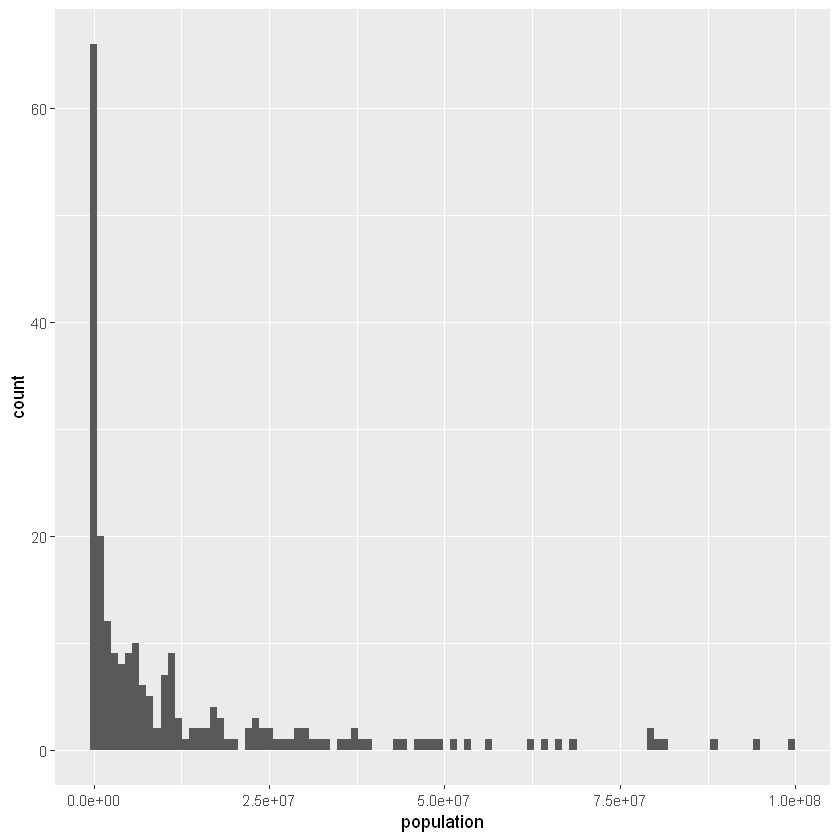

In [19]:
pop_filtered <- result4 %>% filter(population < 100000000)

pop_hist <- ggplot(data=pop_filtered) + aes(x=population) + geom_histogram(bins=100)

pop_hist

We see that an overwhelming majority of countries have a population of 12.5 million or less (note that 2.5e+07 denotes 25 million). There is a very large proportion of countries with populations of 6 million or less that are responsible for the histogram being skewed significantly left. 

## Exploring Population Densities

Population Densities are calculated by dividing a country's total population by its land area. We'll inspect what the highest population densities were in 2015, and see how they might be different from [today's population densities](https://simple.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density).

Our table doesn't have a column on population density yet, but it has the info we need to make one. We'll also need to remove countries with `area_land` listed as 0, so we don't have an infinite population density value.

In [30]:
pop_density <- result4 %>% filter(area_land != 0) %>% mutate(popdensity = population/area_land) 
%>% arrange(desc(popdensity)) %>% select(name, population, area_land, popdensity)

head(pop_density, 10)

name,population,area_land,popdensity
Macau,592731,28,21168.964
Monaco,30535,2,15267.500
Singapore,5674472,687,8259.785
Hong Kong,7141106,1073,6655.271
Gaza Strip,1869055,360,5191.819
Gibraltar,29258,6,4876.333
Bahrain,1346613,760,1771.859
Maldives,393253,298,1319.641
Malta,413965,316,1310.016
Bermuda,70196,54,1299.926


We see from comparing the tibble above to the wikipedia page linked [here](https://simple.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density), that as of July 2019, the table above mostly contains the same countries, in more or less (but not quite exactly) the same order as the table in the wikipedia page. 

The main difference that stands out is that the 'Gaza Strip is listed' as a country above, whereas it was not in the Wiki page.